In [1]:
import os
import torch
from torch import nn
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle

In [2]:
class PhysionetDataset(Dataset):
    def __init__(self, dataset_path, train=True, debug=False, one_hot_encoding=True):
        """
        Args:
            dataset_dir (string): Path to Physionet MMI dataset with .csv extensions
        """
        self.label_map = {'imagine_both_feet': 0, 'imagine_both_fist': 1, 'imagine_left_fist': 2, 'imagine_right_fist': 3}
        self.X = pickle.load(open(dataset_path, 'rb'))
        if train:
            self.y = self.X['train_y']
            self.X = self.X['train_x'].astype(np.float32)
        else:
            self.y = self.X['test_y']
            self.X = self.X['test_x'].astype(np.float32)

        if debug:
            self.y = self.y[:1000]
            self.X = self.X[:1000]

        if one_hot_encoding:
            
            self.y = np.vectorize(self.label_map.__getitem__)(self.y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()

        sample = self.X[idx], self.y[idx]
        return sample

    def get_labels(self):
        return np.unique(self.y)


In [3]:
debug = True

training_data = PhysionetDataset('/home/amar/Desktop/thesis-2022/dataset/train/cross_subject_data_0.pickle', train=True, debug=debug, one_hot_encoding=True)
test_data = PhysionetDataset('/home/amar/Desktop/thesis-2022/dataset/train/cross_subject_data_0.pickle', train=False, debug=debug, one_hot_encoding=True)

In [4]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)


In [5]:
for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]:", X.shape, X.dtype)
    print("Shape of y", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]: torch.Size([64, 64]) torch.float32
Shape of y torch.Size([64]) torch.int64


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=4, bias=True)
    (5): ReLU()
  )
)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/mlp_experiment_1')

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    correct /= size
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    return train_loss.item(), correct

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [16]:
epochs = 5

train_loss = []
test_loss = []
train_acc = []
test_acc = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    loss, acc = train(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(loss)
    train_acc.append(acc)

    loss, acc = test(test_dataloader, model, loss_fn)
    test_loss.append(loss)
    test_acc.append(acc)
print("Done!")

Epoch 1
-----------------------
Train Error: 
 Accuracy: 99.6%, Avg loss: 0.027011 

Test Error: 
 Accuracy: 82.1%, Avg loss: 0.539736 

Epoch 2
-----------------------
Train Error: 
 Accuracy: 99.8%, Avg loss: 0.022476 

Test Error: 
 Accuracy: 82.2%, Avg loss: 0.533311 

Epoch 3
-----------------------
Train Error: 
 Accuracy: 99.9%, Avg loss: 0.019146 

Test Error: 
 Accuracy: 80.5%, Avg loss: 0.538196 

Epoch 4
-----------------------
Train Error: 
 Accuracy: 99.9%, Avg loss: 0.017845 

Test Error: 
 Accuracy: 81.8%, Avg loss: 0.525414 

Epoch 5
-----------------------
Train Error: 
 Accuracy: 99.9%, Avg loss: 0.015251 

Test Error: 
 Accuracy: 81.1%, Avg loss: 0.530078 

Done!


In [17]:
import matplotlib.pyplot as plt

In [2]:
history = pickle.load(open('history.pickle', 'rb'))

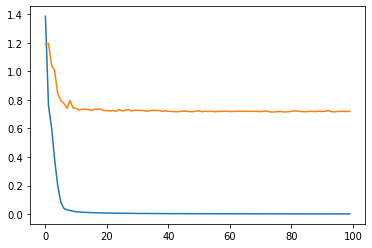

In [5]:
plt.plot(history['train_loss'])
plt.plot(history['test_loss'])
plt.show()

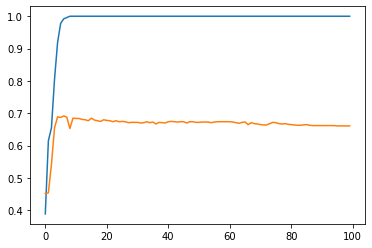

In [6]:
plt.plot(history['train_acc'])
plt.plot(history['test_acc'])
plt.show()